In [96]:
import dask.dataframe as dd
import os
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [97]:
final_dataset_path = '..\data\FEData_For_Modelling.parquet'

# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810


OWH: Outside Work Hours  
WH: Work Hours  
WKE: Weekend  
  
FC: files copied  
SD: Sus Domain  
CD: Cloud Domain  
JD: Job Domain  


In [98]:
def list_files_in_folder(folder_path):
    files = []
    # Check if the folder path exists
    if os.path.exists(folder_path):
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            # Check if the path is a file (not a directory)
            if os.path.isfile(os.path.join(folder_path, file_name)):
                files.append(file_name[7:-4])
    else:
        print(f"Folder '{folder_path}' does not exist.")
    return files

sus_users_list = list_files_in_folder("..\data\\r5.2-2")

In [99]:
print("How many sus users: ",len(sus_users_list))
print(sus_users_list)

How many sus users:  30
['BYO1846', 'CHP1711', 'CIF1430', 'CKP0630', 'DCC1119', 'GWG0497', 'HIS1394', 'HMS1658', 'HSN0675', 'HXP0976', 'ICB1354', 'ITA0159', 'JAL0811', 'KSS1005', 'LVF1626', 'MCP0611', 'MDS0680', 'MGB1235', 'NAH1366', 'OKM1092', 'OSS1463', 'RRS0056', 'SIS0042', 'SNK1280', 'TMT0851', 'TNB1616', 'TRC1838', 'VCF1602', 'WDT1634', 'ZIE0741']


In [100]:
fds

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh
npartitions=1,,,,,,,,,,,,,,,,,,
,string,int8,int8,int8,int8,int8,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [101]:
fds["targetLabel"] = fds['user'].apply(lambda x: 1 if x in sus_users_list else 0, meta=('int'))

In [102]:
(fds["targetLabel"] == 1).sum().compute()

30

In [103]:
y = fds["targetLabel"].compute()
X = fds.drop(columns=["targetLabel","user"]).compute()

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import StandardScaler
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [105]:
# Create a One-Class SVM model
clf = OneClassSVM(nu=0.1) 

# Fit the model on the training data
clf.fit(X_train_scaled) 

OneClassSVM(nu=0.1)

In [106]:
# Create a One-Class SVM model
clf = OneClassSVM(nu=0.1) 

# Fit the model on the training data
clf.fit(X_train_scaled) 

def eval_svm(preds, labels):

    # Convert predictions (-1 for outliers, 1 for inliers) to binary labels (0 for normal, 1 for anomaly)
    pred_labels = np.where(preds == -1, 1, 0)
    print("Pred Outliers:", np.count_nonzero(pred_labels == 1))
    # Compute confusion matrix to get FN and TP
    tn, fp, fn, tp = confusion_matrix(labels, pred_labels).ravel()

    # Evaluate performance metrics
    accuracy = accuracy_score(labels, pred_labels)
    precision = precision_score(labels, pred_labels)
    recall = recall_score(labels, pred_labels)
    f1 = f1_score(labels, pred_labels)

    # Print the performance metrics including FN and TP
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"False Negatives (FN): {fn}")
    print(f"False Positives (FP): {fp}")
    print(f"True Positives (TP): {tp}")

train_pred = clf.predict(X_train_scaled)
print("##############################")
print("Train Evaluation")
print("##############################")
eval_svm(train_pred, y_train)

print()

test_pred = clf.predict(X_test_scaled)
print("##############################")
print("Test Evaluation")
print("##############################")
eval_svm(test_pred, y_test)

##############################
Train Evaluation
##############################
Pred Outliers: 138
Accuracy: 0.8871428571428571
Precision: 0.014492753623188406
Recall: 0.08333333333333333
F1-score: 0.024691358024691357
False Negatives (FN): 22
False Positives (FP): 136
True Positives (TP): 2

##############################
Test Evaluation
##############################
Pred Outliers: 76
Accuracy: 0.8666666666666667
Precision: 0.013157894736842105
Recall: 0.16666666666666666
F1-score: 0.024390243902439025
False Negatives (FN): 5
False Positives (FP): 75
True Positives (TP): 1


## Risk scores

In [107]:
def get_risk_score(clf, X):
    # distance from decision boundary where negative = non anomaly and positive = anomaly
    distances = clf.decision_function(X)
    
    # Map distances to risk scores
    max_distance = np.max(np.abs(distances))
    risk_scores = np.round((0.5 + 0.5 * -distances / max_distance)*100, decimals=2)
    
    return risk_scores


In [108]:
train_risk = get_risk_score(clf, X_train_scaled)
test_risk = get_risk_score(clf, X_test_scaled)

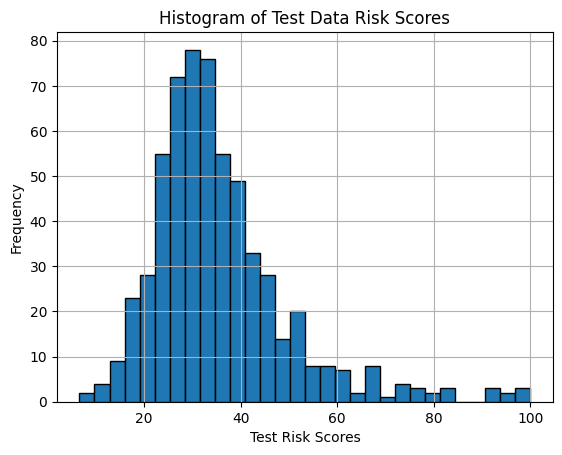

In [109]:
import matplotlib.pyplot as plt
# Plot histogram
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()

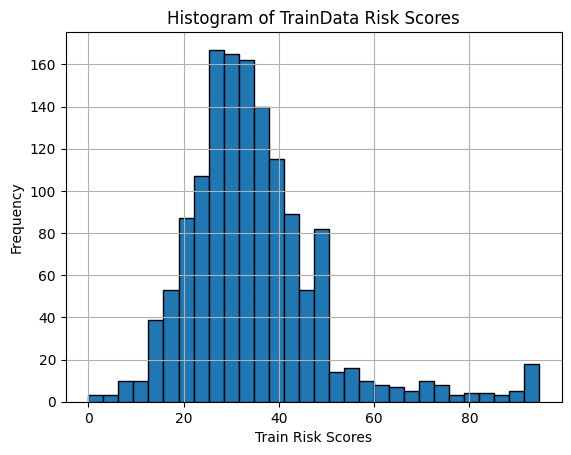

In [110]:
# Plot histogram
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of TrainData Risk Scores')
plt.grid(True)
plt.show()

In [111]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[41.88 73.16 25.64 21.18 43.29 47.4  49.55 35.26 50.   36.88]

Example Test Risk Scores:
[23.6  48.66 38.05 23.69 18.13 40.32 26.24 27.56 68.83 33.45]


## Unimportant experimental stuff

In [112]:
np.count_nonzero(train_risk>=50)

162

In [113]:
np.count_nonzero(train_pred == -1)

138

In [114]:
train_pred_risk = (train_risk > 55).astype(int)
test_pred_risk = (test_risk > 55).astype(int)

In [115]:
train_pred_risk

array([0, 1, 0, ..., 0, 0, 0])

In [116]:
true_positives_indices = np.where((train_pred == -1) & (y_train == 1))[0]


In [117]:
true_positives_indices

array([ 614, 1381], dtype=int64)

In [118]:
train_risk[y_train==1]

array([41.88, 24.19, 43.72, 29.93, 29.28, 28.8 , 41.5 , 18.98, 23.62,
       70.14, 32.03, 36.31, 24.58, 36.29, 20.77, 29.64, 37.21, 31.12,
       27.69, 14.22, 21.4 , 48.13, 46.68, 50.  ])